## Pet-проект по определению отрасли (ОКВЭД) компании. 

### Задача multiclass классификации. 

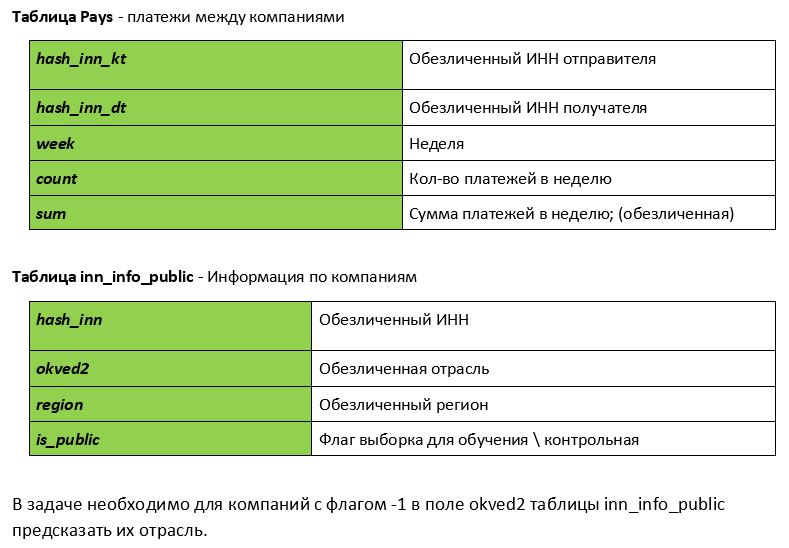

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv

import warnings
warnings.filterwarnings('ignore')

#### EDA

In [5]:
# таблица с платежами между компаниями: 

df_pays = pd.read_csv('pays.csv')
df_pays

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6
...,...,...,...,...,...
5430145,260511,77935,5,2,399.6
5430146,260511,77935,12,2,439.6
5430147,260511,77935,14,2,7.6
5430148,260511,77935,15,2,79.6


In [6]:
df_pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   hash_inn_kt  int64  
 1   hash_inn_dt  int64  
 2   week         int64  
 3   count        int64  
 4   sum          float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [7]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        'Total (всего пропусков)': na,
        'Percent (процент пропусков)': round(100 * na / df.shape[0], 3),
        'Types (тип данных)': df.dtypes
    })
    result = result[result['Total (всего пропусков)'] != 0]
    print(f'Total NA-values (всего пропусков) = {na.sum()}')
    return result.T

In [8]:
check_missings(df_pays)

Total NA-values (всего пропусков) = 1125


,sum
Total (всего пропусков),1125
Percent (процент пропусков),0.021
Types (тип данных),float64


Пропуск в одном признаке и 0,02% - не критично, можно удалить: 

In [9]:
df_pays = df_pays.dropna()

In [10]:
sum(df_pays.duplicated())

0

Дубликаты отсутствуют. 

In [11]:
df_pays.describe()

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5.429025e+06,5.429025e+06,5.429025e+06,5.429025e+06,5.429025e+06
mean,1.288771e+05,1.305208e+05,1.161934e+01,2.920067e+00,3.939404e+02
std,7.569679e+04,7.564682e+04,6.332960e+00,5.050656e+00,7.259421e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-4.000000e-01
25%,6.292900e+04,6.476100e+04,6.000000e+00,1.000000e+00,3.280000e+00
50%,1.273800e+05,1.295880e+05,1.200000e+01,2.000000e+00,1.456800e+01
75%,1.943850e+05,1.966060e+05,1.700000e+01,3.000000e+00,6.920000e+01
max,2.605110e+05,2.605150e+05,2.300000e+01,2.530000e+03,3.966400e+06


Вижу отрицательные значения в признаке sum: это либо платеж в обратную сторону, либо неверные данные: 

In [12]:
df_pays[df_pays['sum'] < 0]

,hash_inn_kt,hash_inn_dt,week,count,sum
27,0,57889,2,3,-0.176
78,0,211495,4,1,-0.216
105,4,173129,22,1,-0.160
106,4,222432,21,1,-0.120
109,4,256873,8,1,-0.040
...,...,...,...,...,...
5429457,260458,250885,10,1,-0.268
5429482,260458,260458,8,2,-0.364
5429483,260458,260458,12,2,-0.132
5429484,260458,260458,20,2,-0.348


In [13]:
# сделаю значения положительными - возьму модуль: 

df_pays['sum'] = abs(df_pays['sum'])

In [14]:
def get_corr(df: pd.DataFrame, threshold: float) -> str:
    """
    Функция определения корреляции между признаками.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления корреляции.
    threshold: float
        Порог значения корреляции, после которого коэффициенты подлежат выводу.

    Returns
    -------
    string: str
        Строки, содержащие признаки и коэффициент корреляции между ними.

    """    
    corr_coef = df.corr()
    corr_field = []
    for i in corr_coef:
        for j in corr_coef.index[corr_coef[i] > threshold]:
            if i != j and j not in corr_field and i not in corr_field:
                corr_field.append(j)
                print (f'Корреляция между признаками {i} и {j}: {corr_coef[i][corr_coef.index==j].values[0]}')

In [15]:
get_corr(df_pays, 0.1)

Корреляция между признаками count и sum: 0.13805809839155586


Корреляции между признаками вообще нет. 

In [16]:
sum(df_pays.duplicated())

0

Дубликатов нет. 

In [17]:
# таблица с информацией по компаниям: 

df_inn = pd.read_csv('inn_info_public.csv')
df_inn

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True
...,...,...,...,...
240064,139170,4,12,True
240065,13553,12,12,True
240066,230402,12,12,True
240067,170104,63,12,True


In [18]:
df_inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hash_inn   240069 non-null  int64
 1   okved2     240069 non-null  int64
 2   region     240069 non-null  int64
 3   is_public  240069 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [19]:
df_inn.describe()

,hash_inn,okved2,region
count,240069.000000,240069.000000,240069.000000
mean,130236.418734,18.771803,58.938343
std,75201.512046,22.078592,26.935958
min,0.000000,-1.000000,0.000000
25%,65170.000000,-1.000000,37.000000
50%,130169.000000,12.000000,60.000000
75%,195380.000000,34.000000,84.000000
max,260515.000000,79.000000,90.000000


In [20]:
check_missings(df_inn)

Total NA-values (всего пропусков) = 0


""
Total (всего пропусков)
Percent (процент пропусков)
Types (тип данных)


-1     0.327631
 12    0.187105
 34    0.056875
 14    0.042400
 4     0.031728
         ...   
 2     0.000375
 36    0.000350
 13    0.000283
 73    0.000267
 1     0.000208
Name: okved2, Length: 81, dtype: float64


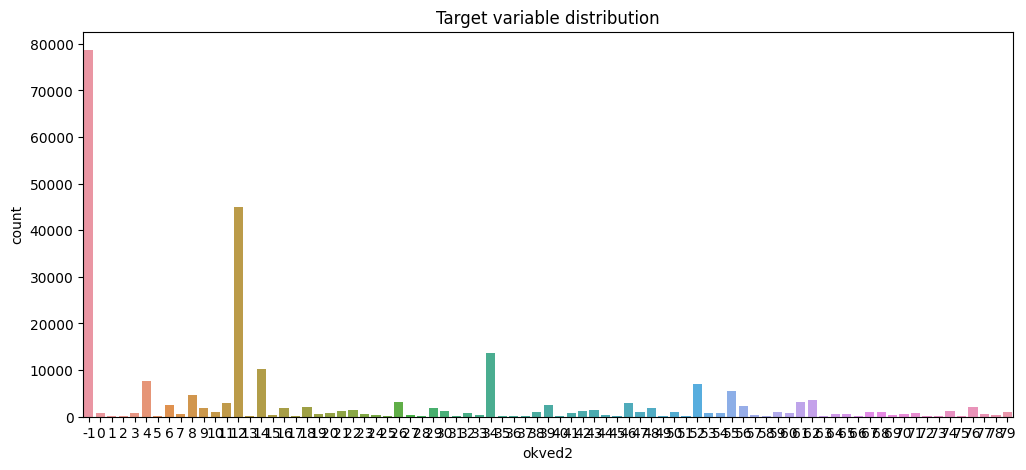

In [21]:
# смотрю распределение целевой переменной okved2:

print(df_inn['okved2'].value_counts(normalize=True))

plt.figure(figsize=(12, 5))
sns.countplot(x='okved2', data=df_inn)
plt.title('Target variable distribution')
plt.show()

Почти 33% надо предсказать. Имеется 80 классов. Наблюдаю дисбаланс. 

In [22]:
df_inn['hash_inn'].value_counts()

61058     1
59492     1
152096    1
89624     1
201826    1
         ..
147361    1
47716     1
243887    1
251550    1
162752    1
Name: hash_inn, Length: 240069, dtype: int64

In [23]:
df_inn['hash_inn'].nunique() == len(df_inn)

True

Во всех строках уникальные ИНН.

In [24]:
sum(df_inn.duplicated())

0

Дубликатов нет. 

### Вижу решение в обогащении датафрейма df_inn (таблица с информацией по компаниям) данными из датафрейма df_pays (таблица с платежами между компаниями) путем мерджа по уникальному ИНН с целью сохранения количества строк в df_inn для правильного сабмишена. 

### Чтобы модель предсказывала класс качественнее, чтобы количество предсказанных классов было оптимальным, чтобы модель не переобучалась на мажорных классах, НЕОБХОДИМО УСТРАНИТЬ ДИСБАЛАНС КЛАССОВ. 

### Для df_pays необходимо сгенерировать дополнительные признаки, которые по транзакционным статистикам смогут выделить поведение организаций в разных категориях бизнеса, В ТОМ ЧИСЛЕ КАТЕГОРИАЛЬНЫЕ - КОТОРЫЕ КОНКРЕТНЕЕ ПОДСКАЖУТ С ПРЕДСКАЗАНИЕМ ОТРАСЛИ (будут в топе важности признаков). 

#### Feature generation (numeric features)

In [25]:
# общее количество платежей за все недели:

df_pays['total_pays_count'] = df_pays['week'] * df_pays['count']

In [26]:
# общая сумма платежей за все недели: 

df_pays['total_pays_sum'] = df_pays['week'] * df_pays['sum']

In [27]:
# общее число покупок: 

df_pays_bought = df_pays['hash_inn_kt'].value_counts().to_frame().reset_index()
df_pays_bought.rename(columns={'hash_inn_kt': 'bought'}, inplace=True)
df_pays_bought.rename(columns={'index': 'hash_inn_kt'}, inplace=True)
df_pays = df_pays.merge(df_pays_bought)

In [28]:
# общее число продаж: 

df_pays_sold = df_pays['hash_inn_dt'].value_counts().to_frame().reset_index()
df_pays_sold.rename(columns={'hash_inn_dt': 'sold'}, inplace=True)
df_pays_sold.rename(columns={'index': 'hash_inn_dt'}, inplace=True)
df_pays = df_pays.merge(df_pays_sold)

In [29]:
# среднее по неделям покупок:

df_pays_bought_weeks_mean = df_pays.groupby('hash_inn_kt')['week'].mean().to_frame().reset_index()
df_pays_bought_weeks_mean.rename(columns={'week': 'bought_weeks_mean'}, inplace=True)
df_pays = df_pays.merge(df_pays_bought_weeks_mean)

In [30]:
# среднее по неделям продаж:

df_pays_sold_weeks_mean = df_pays.groupby('hash_inn_dt')['week'].mean().to_frame().reset_index()
df_pays_sold_weeks_mean.rename(columns={'week': 'sold_weeks_mean'}, inplace=True)
df_pays = df_pays.merge(df_pays_sold_weeks_mean)

In [31]:
# медианное по неделям покупок:

df_pays_bought_weeks_median = df_pays.groupby('hash_inn_kt')['week'].median().to_frame().reset_index()
df_pays_bought_weeks_median.rename(columns={'week': 'bought_weeks_median'}, inplace=True)
df_pays = df_pays.merge(df_pays_bought_weeks_median)

In [32]:
# медианное по неделям продаж:

df_pays_sold_weeks_median = df_pays.groupby('hash_inn_dt')['week'].median().to_frame().reset_index()
df_pays_sold_weeks_median.rename(columns={'week': 'sold_weeks_median'}, inplace=True)
df_pays = df_pays.merge(df_pays_sold_weeks_median)

In [33]:
# среднее по суммам покупок:

df_pays_bought_sum_mean = df_pays.groupby('hash_inn_kt')['sum'].mean().to_frame().reset_index()
df_pays_bought_sum_mean.rename(columns={'sum': 'bought_sum_mean'}, inplace=True)
df_pays = df_pays.merge(df_pays_bought_sum_mean)

In [34]:
# среднее по суммам продаж:

df_pays_sold_sum_mean = df_pays.groupby('hash_inn_dt')['sum'].mean().to_frame().reset_index()
df_pays_sold_sum_mean.rename(columns={'sum': 'sold_sum_mean'}, inplace=True)
df_pays = df_pays.merge(df_pays_sold_sum_mean)

In [35]:
# медианное по суммам покупок:

df_pays_bought_sum_median = df_pays.groupby('hash_inn_kt')['sum'].median().to_frame().reset_index()
df_pays_bought_sum_median.rename(columns={'sum': 'bought_sum_median'}, inplace=True)
df_pays = df_pays.merge(df_pays_bought_sum_median)

In [36]:
# медианное по суммам продаж:

df_pays_sold_sum_median = df_pays.groupby('hash_inn_dt')['sum'].median().to_frame().reset_index()
df_pays_sold_sum_median.rename(columns={'sum': 'sold_sum_median'}, inplace=True)
df_pays = df_pays.merge(df_pays_sold_sum_median)

In [37]:
df_pays

,hash_inn_kt,hash_inn_dt,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median
0,0,0,1,4,38399.600,4,38399.600,85,447,11.000000,12.069351,11.0,12.0,2982.604376,384.858944,399.600,18.192
1,0,0,5,2,399.600,10,1998.000,85,447,11.000000,12.069351,11.0,12.0,2982.604376,384.858944,399.600,18.192
2,0,0,7,2,79.600,14,557.200,85,447,11.000000,12.069351,11.0,12.0,2982.604376,384.858944,399.600,18.192
3,0,0,9,2,239.600,18,2156.400,85,447,11.000000,12.069351,11.0,12.0,2982.604376,384.858944,399.600,18.192
4,0,0,12,2,79.600,24,955.200,85,447,11.000000,12.069351,11.0,12.0,2982.604376,384.858944,399.600,18.192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429020,259603,182682,2,1,44.444,2,88.888,7,1,10.857143,2.000000,11.0,2.0,106.660571,44.444000,104.844,44.444
5429021,259608,259608,16,2,64.400,32,1030.400,1,1,16.000000,16.000000,16.0,16.0,64.400000,64.400000,64.400,64.400
5429022,259624,259624,15,2,0.400,30,6.000,1,1,15.000000,15.000000,15.0,15.0,0.400000,0.400000,0.400,0.400
5429023,260175,260175,9,4,10282.284,36,92540.556,1,1,9.000000,9.000000,9.0,9.0,10282.284000,10282.284000,10282.284,10282.284


#### Feature generation (categorical features) - часть 1

In [38]:
# флаг перевода "самим себе": 

df_pays['self_payed'] = df_pays['hash_inn_kt'] == df_pays['hash_inn_dt']
df_pays['self_payed'] = df_pays['self_payed'].astype(int)

Кажется логичным, что в рамках одной отрасли взаимодействия (платежи) между компаниями должны происходить чаще. Поэтому создаются признаки interactions_kt_dt_freq, interactions_dt_kt_freq - частота взаимодействия покупателя с продавцом (отправителя с получателем) и наоборот: 

In [39]:
df_pays_freq_kt = df_pays.groupby('hash_inn_kt')['hash_inn_dt'].count().to_frame().reset_index()
df_pays_freq_kt.rename(columns={'hash_inn_dt': 'interactions_kt_dt_nums'}, inplace=True)
df_pays_freq_kt

,hash_inn_kt,interactions_kt_dt_nums
0,0,85
1,1,7
2,2,3
3,3,1
4,4,17
...,...,...
152153,260504,34
152154,260507,6
152155,260509,169
152156,260510,3


In [40]:
def fit_freq_kt(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df_pays_freq_kt['interactions_kt_dt_nums'], 0.25):
        res = 1
    elif x < np.quantile(df_pays_freq_kt['interactions_kt_dt_nums'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df_pays_freq_kt['interactions_kt_dt_nums'], 0.75):
        res = 3
    elif x < np.quantile(df_pays_freq_kt['interactions_kt_dt_nums'], 0.9):
        res = 4
    elif x < np.quantile(df_pays_freq_kt['interactions_kt_dt_nums'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [41]:
df_pays_freq_kt['interactions_kt_dt_freq'] = df_pays_freq_kt['interactions_kt_dt_nums'].apply(fit_freq_kt)
df_pays_freq_kt

,hash_inn_kt,interactions_kt_dt_nums,interactions_kt_dt_freq
0,0,85,5
1,1,7,3
2,2,3,2
3,3,1,1
4,4,17,3
...,...,...,...
152153,260504,34,4
152154,260507,6,3
152155,260509,169,6
152156,260510,3,2


In [42]:
df_pays_freq_kt['interactions_kt_dt_freq'].value_counts()

2    43844
3    39225
1    29717
4    24126
6     7640
5     7606
Name: interactions_kt_dt_freq, dtype: int64

И то же самое проанализирую с другой стороны: 

In [43]:
df_pays_freq_dt = df_pays.groupby('hash_inn_dt')['hash_inn_kt'].count().to_frame().reset_index()
df_pays_freq_dt.rename(columns={'hash_inn_kt': 'interactions_dt_kt_nums'}, inplace=True)
df_pays_freq_dt

,hash_inn_dt,interactions_dt_kt_nums
0,0,447
1,2,10
2,5,19
3,7,13
4,10,30
...,...,...
189765,260511,11
189766,260512,11
189767,260513,2
189768,260514,1


In [44]:
def fit_freq_dt(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df_pays_freq_dt['interactions_dt_kt_nums'], 0.25):
        res = 1
    elif x < np.quantile(df_pays_freq_dt['interactions_dt_kt_nums'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df_pays_freq_dt['interactions_dt_kt_nums'], 0.75):
        res = 3
    elif x < np.quantile(df_pays_freq_dt['interactions_dt_kt_nums'], 0.9):
        res = 4
    elif x < np.quantile(df_pays_freq_dt['interactions_dt_kt_nums'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [45]:
df_pays_freq_dt['interactions_dt_kt_freq'] = df_pays_freq_dt['interactions_dt_kt_nums'].apply(fit_freq_dt)
df_pays_freq_dt

,hash_inn_dt,interactions_dt_kt_nums,interactions_dt_kt_freq
0,0,447,6
1,2,10,3
2,5,19,3
3,7,13,3
4,10,30,4
...,...,...,...
189765,260511,11,3
189766,260512,11,3
189767,260513,2,2
189768,260514,1,1


In [46]:
df_pays_freq_dt['interactions_dt_kt_freq'].value_counts()

2    52079
3    49270
1    39424
4    29866
5     9575
6     9556
Name: interactions_dt_kt_freq, dtype: int64

#### Data preparation

In [47]:
# оставляю уникальные значения в столбце hash_inn_kt: 

df_pays_kt = df_pays.groupby(['hash_inn_kt']).mean().reset_index()
df_pays_kt.drop('hash_inn_dt', axis=1, inplace=True)
df_pays_kt = df_pays_kt.rename(columns={'hash_inn_kt': 'hash_inn'})
df_pays_kt

,hash_inn,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed
0,0,11.000000,2.282353,2982.604376,25.552941,21821.391153,85.0,196.847059,11.000000,11.908867,11.0,12.223529,2982.604376,2030.001283,399.600,847.034565,0.117647
1,1,9.428571,2.000000,19.714286,18.857143,202.857143,7.0,517.000000,9.428571,11.098646,9.0,11.000000,19.714286,198.805988,25.200,86.536000,0.000000
2,2,4.666667,1.666667,12.080000,5.333333,33.126667,3.0,254.666667,4.666667,11.304412,1.0,12.333333,12.080000,1646.083666,5.740,22.259333,0.000000
3,3,15.000000,1.000000,13.948000,15.000000,209.220000,1.0,52.000000,15.000000,12.596154,15.0,13.000000,13.948000,73.099154,13.948,14.000000,0.000000
4,4,13.882353,1.058824,0.635294,14.823529,8.856471,17.0,239.764706,13.882353,11.717615,13.0,11.176471,0.635294,257.665139,0.560,41.550353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152153,260504,12.735294,2.823529,255.632941,38.764706,2701.503647,34.0,275.470588,12.735294,11.969252,14.5,12.191176,255.632941,187.037455,181.210,27.382824,0.000000
152154,260507,8.333333,1.500000,23.169333,9.500000,91.326667,6.0,318.000000,8.333333,9.880503,8.5,11.000000,23.169333,33.945849,8.248,6.842000,0.000000
152155,260509,10.721893,3.455621,156.378485,34.183432,1457.161183,169.0,519.704142,10.721893,11.852780,11.0,11.979290,156.378485,210.873797,43.684,44.782000,0.011834
152156,260510,17.333333,1.000000,73.586667,17.333333,1143.306667,3.0,261.000000,17.333333,12.743295,19.0,13.000000,73.586667,42.653916,48.800,15.600000,0.000000


In [48]:
# оставляю уникальные значения в столбце hash_inn_dt: 

df_pays_dt = df_pays.groupby(['hash_inn_dt']).mean().reset_index()
df_pays_dt.drop('hash_inn_kt', axis=1, inplace=True)
df_pays_dt = df_pays_dt.rename(columns={'hash_inn_dt': 'hash_inn'})
df_pays_dt

,hash_inn,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed
0,0,12.069351,2.409396,384.858944,30.505593,3725.210694,1408.950783,447.0,11.812291,12.069351,11.947427,12.0,718.165723,384.858944,465.306689,18.192,0.022371
1,2,11.600000,2.900000,42.748400,31.600000,554.845600,723.000000,10.0,12.842324,11.600000,14.000000,11.5,737.662307,42.748400,121.040000,30.704,0.000000
2,5,8.894737,2.000000,6.533263,17.789474,54.059579,8191.421053,19.0,11.474430,8.894737,11.368421,9.0,39.210497,6.533263,8.856000,0.480,0.000000
3,7,8.230769,1.307692,600.701231,9.076923,2993.156923,284.230769,13.0,11.407983,8.230769,11.192308,6.0,4378.985636,600.701231,465.953846,167.184,0.000000
4,10,8.133333,2.400000,5.087200,23.000000,67.720000,9724.033333,30.0,11.349665,8.133333,11.000000,6.0,268.711913,5.087200,14.177133,2.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189765,260511,15.545455,1.545455,21.992364,24.818182,286.599636,5458.727273,11.0,12.196894,15.545455,12.318182,14.0,64.835953,21.992364,17.325455,7.600,0.090909
189766,260512,14.909091,2.363636,12.210182,36.090909,174.785818,10637.545455,11.0,11.414013,14.909091,11.454545,15.0,251.038038,12.210182,9.433455,6.404,0.000000
189767,260513,7.500000,1.000000,16.448000,7.500000,131.784000,605.000000,2.0,11.595041,7.500000,12.000000,7.5,237.706770,16.448000,47.600000,16.448,0.000000
189768,260514,2.000000,2.000000,162.380000,4.000000,324.760000,299.000000,1.0,11.558528,2.000000,12.000000,2.0,496.524388,162.380000,236.904000,162.380,0.000000


In [49]:
# конкатенирую датафреймы по строкам: 

df_pays_common = pd.concat([df_pays_kt, df_pays_dt], axis=0)
df_pays_common

,hash_inn,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed
0,0,11.000000,2.282353,2982.604376,25.552941,21821.391153,85.000000,196.847059,11.000000,11.908867,11.000000,12.223529,2982.604376,2030.001283,399.600000,847.034565,0.117647
1,1,9.428571,2.000000,19.714286,18.857143,202.857143,7.000000,517.000000,9.428571,11.098646,9.000000,11.000000,19.714286,198.805988,25.200000,86.536000,0.000000
2,2,4.666667,1.666667,12.080000,5.333333,33.126667,3.000000,254.666667,4.666667,11.304412,1.000000,12.333333,12.080000,1646.083666,5.740000,22.259333,0.000000
3,3,15.000000,1.000000,13.948000,15.000000,209.220000,1.000000,52.000000,15.000000,12.596154,15.000000,13.000000,13.948000,73.099154,13.948000,14.000000,0.000000
4,4,13.882353,1.058824,0.635294,14.823529,8.856471,17.000000,239.764706,13.882353,11.717615,13.000000,11.176471,0.635294,257.665139,0.560000,41.550353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189765,260511,15.545455,1.545455,21.992364,24.818182,286.599636,5458.727273,11.000000,12.196894,15.545455,12.318182,14.000000,64.835953,21.992364,17.325455,7.600000,0.090909
189766,260512,14.909091,2.363636,12.210182,36.090909,174.785818,10637.545455,11.000000,11.414013,14.909091,11.454545,15.000000,251.038038,12.210182,9.433455,6.404000,0.000000
189767,260513,7.500000,1.000000,16.448000,7.500000,131.784000,605.000000,2.000000,11.595041,7.500000,12.000000,7.500000,237.706770,16.448000,47.600000,16.448000,0.000000
189768,260514,2.000000,2.000000,162.380000,4.000000,324.760000,299.000000,1.000000,11.558528,2.000000,12.000000,2.000000,496.524388,162.380000,236.904000,162.380000,0.000000


In [50]:
# группирую по hash_inn, оставляя уникальные значения: 

df_pays_common_gb = df_pays_common.groupby(['hash_inn']).mean().reset_index()
df_pays_common_gb

,hash_inn,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed
0,0,11.534676,2.345874,1683.731660,28.029267,12773.300923,746.975391,321.923529,11.406145,11.989109,11.473714,12.111765,1850.385050,1207.430113,432.453345,432.613282,0.070009
1,1,9.428571,2.000000,19.714286,18.857143,202.857143,7.000000,517.000000,9.428571,11.098646,9.000000,11.000000,19.714286,198.805988,25.200000,86.536000,0.000000
2,2,8.133333,2.283333,27.414200,18.466667,293.986133,363.000000,132.333333,8.754495,11.452206,7.500000,11.916667,374.871154,844.416033,63.390000,26.481667,0.000000
3,3,15.000000,1.000000,13.948000,15.000000,209.220000,1.000000,52.000000,15.000000,12.596154,15.000000,13.000000,13.948000,73.099154,13.948000,14.000000,0.000000
4,4,13.882353,1.058824,0.635294,14.823529,8.856471,17.000000,239.764706,13.882353,11.717615,13.000000,11.176471,0.635294,257.665139,0.560000,41.550353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,260511,12.606061,1.772727,95.462848,22.075758,877.366485,2732.363636,62.666667,10.931780,13.802750,11.659091,13.166667,116.884643,1262.557694,48.462727,37.600000,0.128788
240065,260512,14.909091,2.363636,12.210182,36.090909,174.785818,10637.545455,11.000000,11.414013,14.909091,11.454545,15.000000,251.038038,12.210182,9.433455,6.404000,0.000000
240066,260513,7.500000,1.000000,16.448000,7.500000,131.784000,605.000000,2.000000,11.595041,7.500000,12.000000,7.500000,237.706770,16.448000,47.600000,16.448000,0.000000
240067,260514,2.000000,2.000000,162.380000,4.000000,324.760000,299.000000,1.000000,11.558528,2.000000,12.000000,2.000000,496.524388,162.380000,236.904000,162.380000,0.000000


In [51]:
# сравнение размера датафреймов перед мерджем: 

len(df_inn) - len(df_pays_common_gb)

0

Мерджу к датафрейму df_inn датафрейм df_pays_common_gb при помощи how='inner' (устанавливается по умолчанию): 

In [52]:
df = df_inn.merge(df_pays_common_gb)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,sold_weeks_mean,bought_weeks_median,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,4.000000,12.947074,7.750000,14.000000,8.500000,82.560821,22.364000,13.792000,17.604000,0.000000
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,6.000000,11.749104,9.333333,12.000000,9.000000,88.823954,6.749333,16.328000,6.148000,0.000000
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,79.500000,6.732094,12.549884,6.673077,12.750000,321.078894,750.869034,219.950000,143.580000,0.000000
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,11.000000,11.953681,14.181818,12.000000,16.000000,74.402690,19.364727,17.961091,15.840000,0.000000
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,227.000000,7.750000,12.259912,7.500000,12.000000,194.875000,474.166291,104.800000,41.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,480.292308,11.210888,10.973789,11.100904,9.876923,887.369749,461.287520,84.302966,66.911223,0.004449
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,773.818182,9.909091,11.178354,8.000000,10.636364,19.210909,185.866360,11.000000,59.602909,0.000000
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,61.060000,11.425000,9.794414,11.333333,9.180000,159.289053,373.618146,89.380133,297.366240,0.000000
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,81.500000,18.092593,16.407407,18.500000,16.750000,119.253481,132.919963,85.568000,78.148000,0.000000


#### Feature generation (categorical features) - часть 2

In [53]:
# восстанавливаю признак self_payed: 

df.loc[df['self_payed'] > 0, 'self_payed'] = 1
df['self_payed'] = df['self_payed'].astype(int)

In [54]:
# примердживаю частоту взаимодействий, пропуски заполняю нолями: 

df = df.merge(df_pays_freq_kt, left_on='hash_inn', right_on='hash_inn_kt', how='left')
df.drop('hash_inn_kt', axis=1, inplace=True)
df.fillna(0, inplace=True)
df['interactions_kt_dt_freq'] = df['interactions_kt_dt_freq'].astype(int)

df = df.merge(df_pays_freq_dt, left_on='hash_inn', right_on='hash_inn_dt', how='left')
df.drop('hash_inn_dt', axis=1, inplace=True)
df.fillna(0, inplace=True)
df['interactions_dt_kt_freq'] = df['interactions_dt_kt_freq'].astype(int)

df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,sold_weeks_median,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,8.500000,82.560821,22.364000,13.792000,17.604000,0,0.0,0,4.0,2
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,9.000000,88.823954,6.749333,16.328000,6.148000,0,0.0,0,6.0,3
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,12.750000,321.078894,750.869034,219.950000,143.580000,0,2.0,2,26.0,4
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,16.000000,74.402690,19.364727,17.961091,15.840000,0,0.0,0,11.0,3
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,12.000000,194.875000,474.166291,104.800000,41.200000,0,4.0,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,9.876923,887.369749,461.287520,84.302966,66.911223,1,130.0,6,830.0,6
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,10.636364,19.210909,185.866360,11.000000,59.602909,0,11.0,3,0.0,0
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,9.180000,159.289053,373.618146,89.380133,297.366240,0,25.0,4,15.0,3
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,16.750000,119.253481,132.919963,85.568000,78.148000,0,1.0,1,1.0,1


Признак длительности торговых взаимоотношений по неделям:  

In [55]:
def fit_week(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df['week'], 0.25):
        res = 1
    elif x < np.quantile(df['week'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df['week'], 0.75):
        res = 3
    elif x < np.quantile(df['week'], 0.9):
        res = 4
    elif x < np.quantile(df['week'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [56]:
df['week_life'] = df['week'].apply(fit_week)
df['week_life'] = df['week_life'].astype(int)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,bought_sum_mean,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq,week_life
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,82.560821,22.364000,13.792000,17.604000,0,0.0,0,4.0,2,1
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,88.823954,6.749333,16.328000,6.148000,0,0.0,0,6.0,3,1
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,321.078894,750.869034,219.950000,143.580000,0,2.0,2,26.0,4,1
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,74.402690,19.364727,17.961091,15.840000,0,0.0,0,11.0,3,4
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,194.875000,474.166291,104.800000,41.200000,0,4.0,2,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,887.369749,461.287520,84.302966,66.911223,1,130.0,6,830.0,6,2
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,19.210909,185.866360,11.000000,59.602909,0,11.0,3,0.0,0,2
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,159.289053,373.618146,89.380133,297.366240,0,25.0,4,15.0,3,2
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,119.253481,132.919963,85.568000,78.148000,0,1.0,1,1.0,1,6


Признак группировки компаний по количеству платежей в неделю:  

In [57]:
def fit_count(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df['count'], 0.25):
        res = 1
    elif x < np.quantile(df['count'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df['count'], 0.75):
        res = 3
    elif x < np.quantile(df['count'], 0.9):
        res = 4
    elif x < np.quantile(df['count'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [58]:
df['group_count'] = df['count'].apply(fit_count)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,sold_sum_mean,bought_sum_median,sold_sum_median,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq,week_life,group_count
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,22.364000,13.792000,17.604000,0,0.0,0,4.0,2,1,4
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,6.749333,16.328000,6.148000,0,0.0,0,6.0,3,1,2
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,750.869034,219.950000,143.580000,0,2.0,2,26.0,4,1,3
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,19.364727,17.961091,15.840000,0,0.0,0,11.0,3,4,3
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,474.166291,104.800000,41.200000,0,4.0,2,0.0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,461.287520,84.302966,66.911223,1,130.0,6,830.0,6,2,6
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,185.866360,11.000000,59.602909,0,11.0,3,0.0,0,2,3
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,373.618146,89.380133,297.366240,0,25.0,4,15.0,3,2,6
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,132.919963,85.568000,78.148000,0,1.0,1,1.0,1,6,3


Признак группировки компаний по сумме платежа в неделю:  

In [59]:
def fit_sum(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df['sum'], 0.25):
        res = 1
    elif x < np.quantile(df['sum'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df['sum'], 0.75):
        res = 3
    elif x < np.quantile(df['sum'], 0.9):
        res = 4
    elif x < np.quantile(df['sum'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [60]:
df['sum_per_week'] = df['sum'].apply(fit_sum)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,bought_sum_median,sold_sum_median,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq,week_life,group_count,sum_per_week
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,13.792000,17.604000,0,0.0,0,4.0,2,1,4,2
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,16.328000,6.148000,0,0.0,0,6.0,3,1,2,1
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,219.950000,143.580000,0,2.0,2,26.0,4,1,3,4
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,17.961091,15.840000,0,0.0,0,11.0,3,4,3,2
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,104.800000,41.200000,0,4.0,2,0.0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,84.302966,66.911223,1,130.0,6,830.0,6,2,6,6
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,11.000000,59.602909,0,11.0,3,0.0,0,2,3,2
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,89.380133,297.366240,0,25.0,4,15.0,3,2,6,4
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,85.568000,78.148000,0,1.0,1,1.0,1,6,3,4


Признак группировки компаний по общему количеству платежей:  

In [61]:
def fit_total_pays_count(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df['total_pays_count'], 0.25):
        res = 1
    elif x < np.quantile(df['total_pays_count'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df['total_pays_count'], 0.75):
        res = 3
    elif x < np.quantile(df['total_pays_count'], 0.9):
        res = 4
    elif x < np.quantile(df['total_pays_count'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [62]:
df['group_total_pays_count'] = df['total_pays_count'].apply(fit_total_pays_count)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,sold_sum_median,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq,week_life,group_count,sum_per_week,group_total_pays_count
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,17.604000,0,0.0,0,4.0,2,1,4,2,3
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,6.148000,0,0.0,0,6.0,3,1,2,1,3
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,143.580000,0,2.0,2,26.0,4,1,3,4,2
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,15.840000,0,0.0,0,11.0,3,4,3,2,3
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,41.200000,0,4.0,2,0.0,0,1,6,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,66.911223,1,130.0,6,830.0,6,2,6,6,6
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,59.602909,0,11.0,3,0.0,0,2,3,2,2
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,297.366240,0,25.0,4,15.0,3,2,6,4,4
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,78.148000,0,1.0,1,1.0,1,6,3,4,5


Признак группировки компаний по общему денежному обороту:  

In [63]:
def fit_total_pays_sum(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df['total_pays_sum'], 0.25):
        res = 1
    elif x < np.quantile(df['total_pays_sum'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df['total_pays_sum'], 0.75):
        res = 3
    elif x < np.quantile(df['total_pays_sum'], 0.9):
        res = 4
    elif x < np.quantile(df['total_pays_sum'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [64]:
df['group_total_pays_sum'] = df['total_pays_sum'].apply(fit_total_pays_sum)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,self_payed,interactions_kt_dt_nums,interactions_kt_dt_freq,interactions_dt_kt_nums,interactions_dt_kt_freq,week_life,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,0,0.0,0,4.0,2,1,4,2,3,2
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,0,0.0,0,6.0,3,1,2,1,3,1
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,0,2.0,2,26.0,4,1,3,4,2,4
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,0,0.0,0,11.0,3,4,3,2,3,2
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,0,4.0,2,0.0,0,1,6,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,139170,4,12,True,10.906858,6.793652,869.461721,70.338369,6974.691098,120.121084,...,1,130.0,6,830.0,6,2,6,6,6,5
240065,13553,12,12,True,9.909091,2.000000,19.210909,19.818182,159.498182,11.000000,...,0,11.0,3,0.0,0,2,3,2,2,2
240066,230402,12,12,True,9.766667,4.260000,274.244853,33.200000,2553.983147,42.400000,...,0,25.0,4,15.0,3,2,6,4,4,4
240067,170104,63,12,True,21.500000,2.000000,149.496000,43.000000,3214.164000,14.000000,...,0,1.0,1,1.0,1,6,3,4,5,4


Признаки на основе группировок по region: 

Признак отнесения отрасли к разным группам по времени торговых отношений: 

In [65]:
df_region_week = df.groupby('region')['week'].mean().to_frame().reset_index()
df_region_week.rename(columns={'week': 'region_week'}, inplace=True)
df_region_week

,region,region_week
0,0,11.750000
1,1,11.265710
2,2,11.628988
3,3,11.625280
4,4,11.408889
...,...,...
86,86,11.668314
87,87,11.491229
88,88,11.376226
89,89,11.566812


In [66]:
def fit_region_week(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df_region_week['region_week'], 0.25):
        res = 1
    elif x < np.quantile(df_region_week['region_week'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df_region_week['region_week'], 0.75):
        res = 3
    elif x < np.quantile(df_region_week['region_week'], 0.9):
        res = 4
    elif x < np.quantile(df_region_week['region_week'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [67]:
df_region_week['group_region_week'] =df_region_week['region_week'].apply(fit_region_week)
df_region_week

,region,region_week,group_region_week
0,0,11.750000,4
1,1,11.265710,2
2,2,11.628988,4
3,3,11.625280,4
4,4,11.408889,2
...,...,...,...
86,86,11.668314,4
87,87,11.491229,3
88,88,11.376226,2
89,89,11.566812,4


Признак отнесения отрасли к разным группам по количеству платежей в неделю: 

In [68]:
df_region_count = df.groupby('region')['count'].mean().to_frame().reset_index()
df_region_count.rename(columns={'count': 'region_count'}, inplace=True)
df_region_count

,region,region_count
0,0,4.125000
1,1,2.072897
2,2,2.227353
3,3,1.987778
4,4,1.918577
...,...,...
86,86,2.361344
87,87,2.320133
88,88,2.185486
89,89,1.992179


In [69]:
def fit_region_count(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df_region_count['region_count'], 0.25):
        res = 1
    elif x < np.quantile(df_region_count['region_count'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df_region_count['region_count'], 0.75):
        res = 3
    elif x < np.quantile(df_region_count['region_count'], 0.9):
        res = 4
    elif x < np.quantile(df_region_count['region_count'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [70]:
df_region_count['group_region_count'] =df_region_count['region_count'].apply(fit_region_count)
df_region_count

,region,region_count,group_region_count
0,0,4.125000,6
1,1,2.072897,2
2,2,2.227353,3
3,3,1.987778,2
4,4,1.918577,1
...,...,...,...
86,86,2.361344,4
87,87,2.320133,4
88,88,2.185486,3
89,89,1.992179,2


Признак отнесения отрасли к разным группам по сумме платежей в неделю: 

In [71]:
df_region_sum = df.groupby('region')['sum'].mean().to_frame().reset_index()
df_region_sum.rename(columns={'sum': 'region_sum'}, inplace=True)
df_region_sum

,region,region_sum
0,0,1.820000
1,1,156.043715
2,2,208.216146
3,3,143.473245
4,4,360.077941
...,...,...
86,86,197.169360
87,87,300.700247
88,88,222.575289
89,89,94.926924


In [72]:
def fit_region_sum(x):
    if x == 0:
        res = 0
    elif x < np.quantile(df_region_sum['region_sum'], 0.25):
        res = 1
    elif x < np.quantile(df_region_sum['region_sum'], 0.5): # медиана
        res = 2
    elif x < np.quantile(df_region_sum['region_sum'], 0.75):
        res = 3
    elif x < np.quantile(df_region_sum['region_sum'], 0.9):
        res = 4
    elif x < np.quantile(df_region_sum['region_sum'], 0.95):
        res = 5
    else:
        res = 6
    return res

In [73]:
df_region_sum['group_region_sum'] =df_region_sum['region_sum'].apply(fit_region_sum)
df_region_sum

,region,region_sum,group_region_sum
0,0,1.820000,1
1,1,156.043715,2
2,2,208.216146,3
3,3,143.473245,1
4,4,360.077941,5
...,...,...,...
86,86,197.169360,2
87,87,300.700247,4
88,88,222.575289,3
89,89,94.926924,1


In [74]:
# мерджи по region:

df = df.merge(df_region_week)
df = df.merge(df_region_count)
df = df.merge(df_region_sum)
df

,hash_inn,okved2,region,is_public,week,count,sum,total_pays_count,total_pays_sum,bought,...,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum
0,61058,34,86,True,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,...,4,2,3,2,11.668314,4,2.361344,4,197.169360,2
1,8311,18,86,True,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,...,2,1,3,1,11.668314,4,2.361344,4,197.169360,2
2,130273,-1,86,False,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,...,3,4,2,4,11.668314,4,2.361344,4,197.169360,2
3,64081,43,86,True,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,...,3,2,3,2,11.668314,4,2.361344,4,197.169360,2
4,218005,12,86,True,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,...,6,4,4,4,11.668314,4,2.361344,4,197.169360,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,31660,49,63,True,11.750000,1.250000,4.303000,14.750000,55.458000,4.000000,...,1,1,2,1,12.440476,6,1.857143,1,576.998302,6
240065,167223,32,63,True,19.333333,1.000000,38.704000,19.333333,737.877333,3137.333333,...,1,3,2,3,12.440476,6,1.857143,1,576.998302,6
240066,208641,8,63,True,14.750000,2.750000,3864.703111,43.583333,66156.414778,288.222222,...,4,6,5,6,12.440476,6,1.857143,1,576.998302,6
240067,186082,2,63,True,10.500000,1.500000,25.394000,18.500000,335.970000,25.500000,...,2,2,2,3,12.440476,6,1.857143,1,576.998302,6


Получен обогащенный датафрейм для обучения с нужным размером. 

#### Разделение на train и test

In [75]:
df_train = df[df['is_public'] == True]
df_train.drop('is_public', axis=1, inplace=True)
df_train

,hash_inn,okved2,region,week,count,sum,total_pays_count,total_pays_sum,bought,sold,...,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum
0,61058,34,86,7.750000,3.000000,22.364000,23.250000,120.320000,3760.000000,4.000000,...,4,2,3,2,11.668314,4,2.361344,4,197.169360,2
1,8311,18,86,9.333333,1.833333,6.749333,22.166667,69.450000,5301.000000,6.000000,...,2,1,3,1,11.668314,4,2.361344,4,197.169360,2
3,64081,43,86,14.181818,2.000000,19.364727,28.363636,260.030909,263.272727,11.000000,...,3,2,3,2,11.668314,4,2.361344,4,197.169360,2
4,218005,12,86,7.750000,5.000000,194.875000,35.750000,1282.378000,4.000000,227.000000,...,6,4,4,4,11.668314,4,2.361344,4,197.169360,2
5,159729,34,86,9.037037,1.518519,3.673852,15.592593,42.223852,1182.203704,31.000000,...,2,1,2,1,11.668314,4,2.361344,4,197.169360,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240064,31660,49,63,11.750000,1.250000,4.303000,14.750000,55.458000,4.000000,1249.000000,...,1,1,2,1,12.440476,6,1.857143,1,576.998302,6
240065,167223,32,63,19.333333,1.000000,38.704000,19.333333,737.877333,3137.333333,3.000000,...,1,3,2,3,12.440476,6,1.857143,1,576.998302,6
240066,208641,8,63,14.750000,2.750000,3864.703111,43.583333,66156.414778,288.222222,339.166667,...,4,6,5,6,12.440476,6,1.857143,1,576.998302,6
240067,186082,2,63,10.500000,1.500000,25.394000,18.500000,335.970000,25.500000,2.000000,...,2,2,2,3,12.440476,6,1.857143,1,576.998302,6


In [76]:
df_test = df[df['is_public'] == False]
df_test.drop(['okved2', 'is_public'], axis=1, inplace=True)
df_test

,hash_inn,region,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,...,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum
2,130273,86,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,79.500000,6.732094,...,3,4,2,4,11.668314,4,2.361344,4,197.169360,2
7,205011,86,12.697115,2.519231,85.294558,32.432692,1094.049308,891.884615,74.500000,12.522743,...,3,3,4,3,11.668314,4,2.361344,4,197.169360,2
13,27440,86,7.250000,3.000000,21.838000,21.750000,182.768000,3760.000000,4.000000,12.947074,...,4,2,2,2,11.668314,4,2.361344,4,197.169360,2
15,34209,86,15.166667,1.333333,30.058222,21.777778,581.822444,1191.222222,18.000000,12.633608,...,2,2,2,3,11.668314,4,2.361344,4,197.169360,2
20,124125,86,18.000000,2.000000,1039.600000,36.000000,18712.800000,712.000000,1.000000,14.794944,...,3,6,4,6,11.668314,4,2.361344,4,197.169360,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240045,177955,31,11.166667,1.250000,327.064667,13.916667,5634.362667,912.166667,12.000000,11.443543,...,1,4,1,5,11.895960,5,1.692451,1,240.020458,3
240051,116806,31,5.000000,2.000000,31.600000,10.000000,158.000000,1.000000,1723.000000,5.000000,...,3,3,1,2,11.895960,5,1.692451,1,240.020458,3
240055,154135,79,11.666667,1.000000,14.380000,11.666667,165.244000,13578.000000,3.000000,12.246428,...,1,2,1,2,9.541667,1,1.250000,1,90.365000,1
240057,224875,75,8.533333,3.333333,737.014667,18.400000,4657.269467,160.100000,446.166667,8.170016,...,5,5,2,5,12.758333,6,2.083333,3,991.838167,6


Была измерена метрика F1 на следующих моделях: RandomForestClassifier, LogisticRegression, KNeighborsClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier. 

Останавливаюсь на классификаторе от CatBoost. 

#### CatBoost

In [77]:
train, test = train_test_split(df_train, train_size=0.6, random_state=42, stratify=df_train['okved2'])

In [78]:
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['okved2'])

Отбор признаков: 

In [80]:
train.head()

,hash_inn,okved2,region,week,count,sum,total_pays_count,total_pays_sum,bought,sold,...,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum
183011,237371,39,72,14.442308,1.846154,40.637923,27.153846,669.684923,93.750000,170.384615,...,2,3,3,3,11.609596,4,2.090633,3,167.702859,2
22434,195185,41,84,11.281818,3.309091,96.482455,37.390909,1080.933418,723.027273,501.045455,...,4,3,4,3,11.756786,5,2.230654,4,331.662179,4
32334,235854,16,84,8.675000,2.650000,19.666150,24.937500,138.880650,3483.468750,14.600000,...,4,2,3,2,11.756786,5,2.230654,4,331.662179,4
90226,67556,53,20,10.757692,5.157692,30.386323,54.967308,422.107338,856.538462,973.000000,...,6,3,6,3,11.149847,1,1.982676,2,285.280189,3
76762,210258,55,80,15.952381,1.000000,5.704095,15.952381,99.105238,123.000000,159.714286,...,1,1,2,2,11.539129,3,2.637723,6,180.849219,2


In [81]:
train.columns

Index(['hash_inn', 'okved2', 'region', 'week', 'count', 'sum',
       'total_pays_count', 'total_pays_sum', 'bought', 'sold',
       'bought_weeks_mean', 'sold_weeks_mean', 'bought_weeks_median',
       'sold_weeks_median', 'bought_sum_mean', 'sold_sum_mean',
       'bought_sum_median', 'sold_sum_median', 'self_payed',
       'interactions_kt_dt_nums', 'interactions_kt_dt_freq',
       'interactions_dt_kt_nums', 'interactions_dt_kt_freq', 'week_life',
       'group_count', 'sum_per_week', 'group_total_pays_count',
       'group_total_pays_sum', 'region_week', 'group_region_week',
       'region_count', 'group_region_count', 'region_sum', 'group_region_sum'],
      dtype='object')

In [82]:
X = ['region', 'week', 'count', 'sum',
       'total_pays_count', 'total_pays_sum', 'bought', 'sold',
       'bought_weeks_mean', 'sold_weeks_mean', 'bought_weeks_median',
       'sold_weeks_median', 'bought_sum_mean', 'sold_sum_mean',
       'bought_sum_median', 'sold_sum_median', 'self_payed',
       'interactions_kt_dt_nums', 'interactions_kt_dt_freq',
       'interactions_dt_kt_nums', 'interactions_dt_kt_freq', 'week_life',
       'group_count', 'sum_per_week', 'group_total_pays_count',
       'group_total_pays_sum', 'region_week', 'group_region_week',
       'region_count', 'group_region_count', 'region_sum', 'group_region_sum'] # без целевой переменной okved2 и hash_inn

y = ['okved2'] # целевая переменная

cat_features = ['region', 'self_payed', 'interactions_kt_dt_freq',
       'interactions_dt_kt_freq', 'week_life', 'group_count', 'sum_per_week',
       'group_total_pays_count', 'group_total_pays_sum', 'group_region_week',
       'group_region_count', 'group_region_sum'] # категориальные признаки

Устранение дисбаланса классов. Это позволит снизить переобучение модели и прогнозировать большее количество отраслей. 

В идеале: сделать оверсэмплинг до количества преобладающего класса, но в таком случае обучение у меня будет длиться 11 с лишним дней. 

Поэтому я вручную подтянул минорные классы до такого уровня, чтобы можно было обучаться на GPU и не так долго. 

12    0.278279
34    0.084585
14    0.063057
4     0.047187
52    0.043284
        ...   
2     0.000558
36    0.000516
13    0.000423
73    0.000392
1     0.000310
Name: okved2, Length: 80, dtype: float64


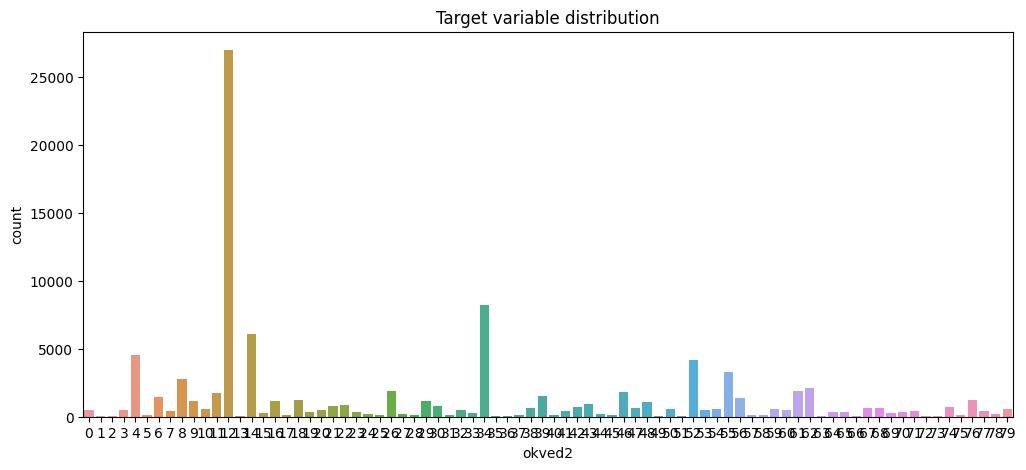

In [83]:
# смотрю распределение целевой переменной okved2:

print(train[y]['okved2'].value_counts(normalize=True))

plt.figure(figsize=(12, 5))
sns.countplot(x='okved2', data=train[y])
plt.title('Target variable distribution')
plt.show()

In [84]:
# создаю словарь для определения размеров выборок в каждом классе: 

class_weights_dict = {}

for i in range(train[y]['okved2'].nunique()):
    class_weights_dict[i] = 8192
    
class_weights_dict[12] = max(Counter(train[y]['okved2']).values())

In [85]:
smote = SMOTE(sampling_strategy=class_weights_dict, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(train[X], train[y])

In [86]:
print("ДО оверсэмплинга :", Counter(train[y]['okved2']))
print('\n')
print("ПОСЛЕ оверсэмплинга :", Counter(y_train_smote['okved2']))

ДО оверсэмплинга : Counter({12: 26951, 34: 8192, 14: 6107, 4: 4570, 52: 4192, 55: 3296, 8: 2795, 62: 2099, 61: 1916, 26: 1885, 46: 1781, 11: 1710, 39: 1546, 6: 1474, 56: 1384, 76: 1235, 18: 1200, 29: 1143, 9: 1132, 16: 1124, 48: 1108, 43: 926, 22: 831, 30: 778, 21: 752, 42: 724, 74: 679, 38: 662, 47: 640, 68: 626, 67: 613, 10: 604, 50: 596, 79: 569, 59: 550, 54: 532, 20: 511, 3: 505, 0: 489, 53: 472, 32: 469, 60: 461, 71: 454, 41: 445, 7: 389, 77: 386, 70: 361, 19: 336, 23: 334, 65: 323, 64: 311, 33: 278, 15: 262, 69: 262, 24: 233, 78: 228, 44: 203, 27: 168, 57: 158, 28: 152, 5: 150, 17: 145, 40: 140, 58: 133, 25: 122, 75: 112, 37: 106, 45: 104, 31: 100, 51: 84, 35: 76, 72: 74, 49: 62, 63: 60, 66: 56, 2: 54, 36: 50, 13: 41, 73: 38, 1: 30})


ПОСЛЕ оверсэмплинга : Counter({12: 26951, 39: 8192, 41: 8192, 16: 8192, 53: 8192, 55: 8192, 34: 8192, 60: 8192, 3: 8192, 78: 8192, 0: 8192, 48: 8192, 10: 8192, 50: 8192, 23: 8192, 14: 8192, 61: 8192, 70: 8192, 66: 8192, 76: 8192, 20: 8192, 26: 8192

12    0.039980
39    0.012152
1     0.012152
33    0.012152
58    0.012152
        ...   
46    0.012152
79    0.012152
4     0.012152
36    0.012152
73    0.012152
Name: okved2, Length: 80, dtype: float64


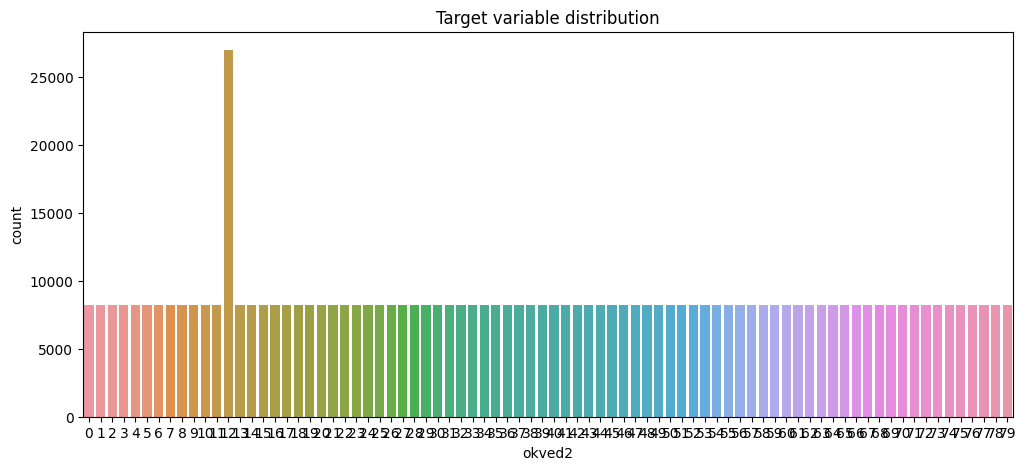

In [87]:
# смотрю распределение целевой переменной okved2 после оверсэмплинга:

print(y_train_smote['okved2'].value_counts(normalize=True))

plt.figure(figsize=(12, 5))
sns.countplot(x='okved2', data=y_train_smote)
plt.title('Target variable distribution')
plt.show()

In [88]:
parameters = {
             'cat_features': cat_features,
             'loss_function': 'MultiClass',
             'task_type': 'GPU',
             'random_seed': 42,
             'verbose': 100
              }

In [89]:
cb_clf = CatBoostClassifier(**parameters)

Следует отметить, что ресэмпл применяется только к обучающим данным. Я просто балансирую обучающие данные, а валидационные данные остаются как есть (исходное распределение). Если я передискретизирую валидационную выборку или все данные, это может вызвать утечку данных. 

In [90]:
cb_clf.fit(X_train_smote, y_train_smote, eval_set=(val[X], val[y]))

Learning rate set to 0.203018
0:	learn: 4.2263540	test: 4.1522207	best: 4.1522207 (0)	total: 1.65s	remaining: 27m 23s
100:	learn: 2.7339711	test: 3.1357574	best: 3.1357574 (100)	total: 2m 41s	remaining: 23m 57s
200:	learn: 2.2303716	test: 3.0594973	best: 3.0593617 (198)	total: 5m 19s	remaining: 21m 10s
300:	learn: 1.9315101	test: 3.0481479	best: 3.0462175 (264)	total: 7m 57s	remaining: 18m 29s
400:	learn: 1.7445573	test: 3.0544172	best: 3.0456498 (307)	total: 10m 35s	remaining: 15m 49s
500:	learn: 1.6116173	test: 3.0668163	best: 3.0456498 (307)	total: 13m 13s	remaining: 13m 10s
600:	learn: 1.4983970	test: 3.0807589	best: 3.0456498 (307)	total: 15m 51s	remaining: 10m 31s
700:	learn: 1.4072832	test: 3.0950926	best: 3.0456498 (307)	total: 18m 28s	remaining: 7m 52s
800:	learn: 1.3180687	test: 3.1128765	best: 3.0456498 (307)	total: 21m 6s	remaining: 5m 14s
900:	learn: 1.2420499	test: 3.1325173	best: 3.0456498 (307)	total: 23m 44s	remaining: 2m 36s
999:	learn: 1.1790078	test: 3.1501397	best:

In [91]:
# важность признаков:

cb_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,bought,12.317581
1,bought_sum_median,7.491327
2,bought_sum_mean,6.716503
3,sold_sum_mean,6.018179
4,region_sum,5.848402
5,sold,5.354422
6,interactions_kt_dt_nums,5.272756
7,interactions_dt_kt_nums,4.465626
8,total_pays_sum,4.377973
9,sold_sum_median,4.331744


Сгенерированные признаки вносят весомый вклад в обучение модели.

In [92]:
# прогноз отрасли для метрики: 

test['pred_okved2'] = cb_clf.predict(test[X])

Метрика F1 является наиболее подходящей мерой для несбалансированных моделей наборов данных. Поэтому для оценки эффективности модели я использую метрику F1:

In [93]:
# метрика F1: 

f1_score(test['okved2'], test['pred_okved2'], average='micro')

0.3039680327107146

In [94]:
# classification report:

print(classification_report(test['okved2'], test['pred_okved2']))

              precision    recall  f1-score   support

           0       0.03      0.01      0.02       163
           1       0.00      0.00      0.00        10
           2       0.09      0.28      0.13        18
           3       0.06      0.04      0.04       168
           4       0.29      0.06      0.11      1524
           5       0.00      0.00      0.00        50
           6       0.18      0.14      0.16       491
           7       0.00      0.00      0.00       130
           8       0.22      0.03      0.06       932
           9       0.16      0.05      0.07       378
          10       0.04      0.01      0.02       201
          11       0.32      0.31      0.31       570
          12       0.35      0.77      0.48      8983
          13       0.00      0.00      0.00        13
          14       0.33      0.37      0.35      2036
          15       0.07      0.03      0.05        87
          16       0.10      0.10      0.10       375
          17       0.02    

#### Предсказание отрасли

In [95]:
# тестовый датасет: 

df_test

,hash_inn,region,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,...,group_count,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum
2,130273,86,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,79.500000,6.732094,...,3,4,2,4,11.668314,4,2.361344,4,197.169360,2
7,205011,86,12.697115,2.519231,85.294558,32.432692,1094.049308,891.884615,74.500000,12.522743,...,3,3,4,3,11.668314,4,2.361344,4,197.169360,2
13,27440,86,7.250000,3.000000,21.838000,21.750000,182.768000,3760.000000,4.000000,12.947074,...,4,2,2,2,11.668314,4,2.361344,4,197.169360,2
15,34209,86,15.166667,1.333333,30.058222,21.777778,581.822444,1191.222222,18.000000,12.633608,...,2,2,2,3,11.668314,4,2.361344,4,197.169360,2
20,124125,86,18.000000,2.000000,1039.600000,36.000000,18712.800000,712.000000,1.000000,14.794944,...,3,6,4,6,11.668314,4,2.361344,4,197.169360,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240045,177955,31,11.166667,1.250000,327.064667,13.916667,5634.362667,912.166667,12.000000,11.443543,...,1,4,1,5,11.895960,5,1.692451,1,240.020458,3
240051,116806,31,5.000000,2.000000,31.600000,10.000000,158.000000,1.000000,1723.000000,5.000000,...,3,3,1,2,11.895960,5,1.692451,1,240.020458,3
240055,154135,79,11.666667,1.000000,14.380000,11.666667,165.244000,13578.000000,3.000000,12.246428,...,1,2,1,2,9.541667,1,1.250000,1,90.365000,1
240057,224875,75,8.533333,3.333333,737.014667,18.400000,4657.269467,160.100000,446.166667,8.170016,...,5,5,2,5,12.758333,6,2.083333,3,991.838167,6


In [96]:
# предсказание: 

df_test['y'] = cb_clf.predict(df_test[X])
df_test

,hash_inn,region,week,count,sum,total_pays_count,total_pays_sum,bought,sold,bought_weeks_mean,...,sum_per_week,group_total_pays_count,group_total_pays_sum,region_week,group_region_week,region_count,group_region_count,region_sum,group_region_sum,y
2,130273,86,7.711538,2.365385,329.503846,20.000000,2529.819231,350.730769,79.500000,6.732094,...,4,2,4,11.668314,4,2.361344,4,197.169360,2,12
7,205011,86,12.697115,2.519231,85.294558,32.432692,1094.049308,891.884615,74.500000,12.522743,...,3,4,3,11.668314,4,2.361344,4,197.169360,2,12
13,27440,86,7.250000,3.000000,21.838000,21.750000,182.768000,3760.000000,4.000000,12.947074,...,2,2,2,11.668314,4,2.361344,4,197.169360,2,34
15,34209,86,15.166667,1.333333,30.058222,21.777778,581.822444,1191.222222,18.000000,12.633608,...,2,2,3,11.668314,4,2.361344,4,197.169360,2,52
20,124125,86,18.000000,2.000000,1039.600000,36.000000,18712.800000,712.000000,1.000000,14.794944,...,6,4,6,11.668314,4,2.361344,4,197.169360,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240045,177955,31,11.166667,1.250000,327.064667,13.916667,5634.362667,912.166667,12.000000,11.443543,...,4,1,5,11.895960,5,1.692451,1,240.020458,3,66
240051,116806,31,5.000000,2.000000,31.600000,10.000000,158.000000,1.000000,1723.000000,5.000000,...,3,1,2,11.895960,5,1.692451,1,240.020458,3,8
240055,154135,79,11.666667,1.000000,14.380000,11.666667,165.244000,13578.000000,3.000000,12.246428,...,2,1,2,9.541667,1,1.250000,1,90.365000,1,12
240057,224875,75,8.533333,3.333333,737.014667,18.400000,4657.269467,160.100000,446.166667,8.170016,...,5,2,5,12.758333,6,2.083333,3,991.838167,6,12


In [97]:
# формирвоание датасета: 

df_submission = df_test.loc[:, ['hash_inn', 'y']]
df_submission

,hash_inn,y
2,130273,12
7,205011,12
13,27440,34
15,34209,52
20,124125,12
...,...,...
240045,177955,66
240051,116806,8
240055,154135,12
240057,224875,12


In [99]:
df_submission['y'].value_counts()

12    48112
14     5534
34     4574
52     1787
11     1243
      ...  
63       68
25       68
60       65
73       65
1        45
Name: y, Length: 80, dtype: int64

### Модель прогнозирует все отрасли. 